# Understanding the Fourier Transform by example
How to implement the Fast Fourier Transform algorithm in Python from scratch. <br />
@author: Simon J. Buehrer <br />
@date: 2021-02-04 <br /><br />
**Links:**
<ul>
<li> https://towardsdatascience.com/fast-fourier-transform-937926e591cb </li>
<li> https://www.ritchievink.com/blog/2017/04/23/understanding-the-fourier-transform-by-example/ </li>
<li> https://towardsdatascience.com/analyzing-seasonality-with-fourier-transforms-using-python-scipy-bb46945a23d3 </li>
</ul> 

In [12]:
# Additional functions for analysing and manipulating data
import pandas as pd 
# Date Functions
import datetime as dt 

import yfinance as yf #pip install yfinance /or pip3 /or conda
import numpy as np
import statsmodels.api as sm
from scipy.signal import find_peaks

# Important package for visualization - we use this to plot the market data
import matplotlib.pyplot as plt 

import math



## get data

In [13]:
#get current day and download hist. data 
today = dt.datetime.today().strftime('%Y-%m-%d')
hist = (dt.datetime.today()-dt.timedelta(5000)).strftime('%Y-%m-%d')

stockname='MSFT'
print(today,hist)
stockdata_df = yf.download(stockname, start=hist, end=today)
print(stockdata_df.tail(5))

2021-02-07 2007-06-01
[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2021-02-01  235.059998  242.500000  232.429993  239.649994  239.649994   
2021-02-02  241.300003  242.309998  238.690002  239.509995  239.509995   
2021-02-03  239.570007  245.089996  239.259995  243.000000  243.000000   
2021-02-04  242.660004  243.240005  240.369995  242.009995  242.009995   
2021-02-05  242.229996  243.279999  240.419998  242.199997  242.199997   

              Volume  
Date                  
2021-02-01  33314200  
2021-02-02  25916300  
2021-02-03  27158100  
2021-02-04  25296100  
2021-02-05  18043900  


## Calculating the difference (OLS)
und e neui column dezue tue wel datum müesam isch

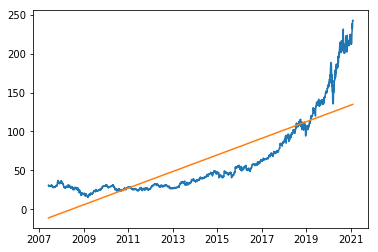

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     7489.
Date:                Sun, 07 Feb 2021   Prob (F-statistic):               0.00
Time:                        20:13:07   Log-Likelihood:                -16449.
No. Observations:                3447   AIC:                         3.290e+04
Df Residuals:                    3445   BIC:                         3.291e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.1466      0.974    -11.445      0.0

In [14]:
stockdata_df['row_num'] = np.arange(len(stockdata_df))
X = sm.add_constant(stockdata_df['row_num']) 
model = sm.OLS(stockdata_df['Close'], X).fit()
stockdata_df['OLS'] = model.predict(X) 

plt.plot(stockdata_df.index,stockdata_df['Close']) 
plt.plot(stockdata_df.index,stockdata_df['OLS'])
plt.show() 
print(model.summary())

stockdata_df['Diff']=stockdata_df['Close']-stockdata_df['OLS']

## es paar Diagramm
Afoch welis chan

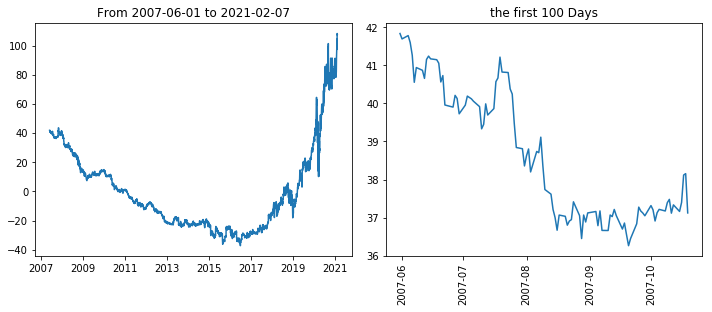

In [15]:
plt.figure(figsize=(10, 4))

ax1 = plt.subplot( 1, 2, 1 )
ax1.plot(stockdata_df.index,stockdata_df['Diff']) 
ax1.set_title("From " + hist + " to " +today)

N=100
ax2 = plt.subplot( 1, 2, 2 )
ax2.plot(stockdata_df.index[:N],stockdata_df['Diff'][:N]) 
ax2.set_title("the first " + str(N) +" Days")

plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

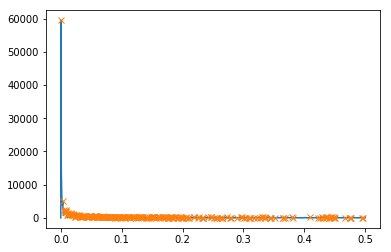

241


In [16]:
fft_output = np.fft.fft(stockdata_df['Diff'])
power = np.abs(fft_output)
freq = np.fft.fftfreq(len(stockdata_df['Diff']))

# mask susch au negativi drinää
mask = freq >= 0
freq = freq[mask]
power = power[mask]

peaks, _ = find_peaks(power[freq >=0], height=100)

plt.plot(freq,power)
plt.plot(freq[peaks], power[peaks],'x')
plt.show() 
print(len(peaks))


In [17]:
output = pd.DataFrame()
output['index'] = peaks
output['freq'] = freq[peaks]
output['amplitude'] = power[peaks]
output['fft'] = fft_output[peaks]
output = output.sort_values('amplitude', ascending=False)

output.head()

,index,freq,amplitude,fft
0,1,0.000290,59499.182720,57680.848988-14596.999841j
1,11,0.003191,5072.192563,1983.026478+4668.484056j
2,18,0.005222,2506.168809,-316.588276+2486.092106j
5,27,0.007833,2467.277419,1507.544730+1953.142788j
4,25,0.007253,2151.278264,1211.415704+1777.771122j


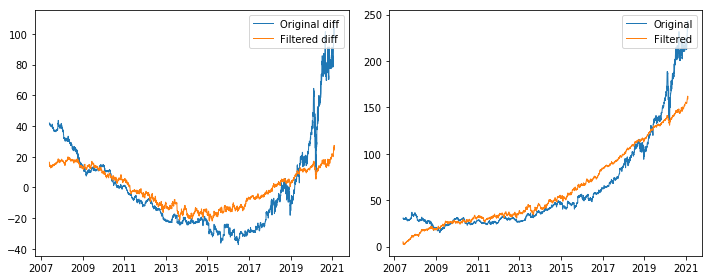

In [18]:
filtered_fft_output = np.array([f if i in list(output['index']) else 0 for i, f in enumerate(fft_output)])
filtered_diff = np.fft.ifft(filtered_fft_output)

stockdata_df['Filtered']=stockdata_df['OLS']+filtered_diff

plt.figure(figsize=(10, 4))
ax1 = plt.subplot( 1, 2, 1 )
ax1.plot(stockdata_df.index, stockdata_df['Diff'], linewidth=1, label='Original diff')
ax1.plot(stockdata_df.index, filtered_diff.real, linewidth=1, label='Filtered diff')
ax1.legend(loc='upper right')

ax2 = plt.subplot( 1, 2, 2 )
ax2.plot(stockdata_df.index, stockdata_df['Close'], linewidth=1, label='Original')
ax2.plot(stockdata_df.index, stockdata_df['Filtered'], linewidth=1, label='Filtered')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


## Incorporating into our regression

The problem with these sinusoids is that the amplitude is off!

In [19]:
from cmath import phase

fourier_terms = pd.DataFrame()
fourier_terms['fft'] = output['fft']
fourier_terms['freq'] = output['freq']
fourier_terms['amplitude'] = fourier_terms.fft.apply(lambda z: abs(z)) 
fourier_terms['phase'] = fourier_terms.fft.apply(lambda z: phase(z))
fourier_terms.sort_values(by=['amplitude'], ascending=[0])

# Create some helpful labels (FT_1..FT_N)
fourier_terms['label'] = list(map(lambda n : 'FT_{}'.format(n), range(1, len(fourier_terms) + 1)))

# Turn our dataframe into a dictionary for easy lookup
fourier_terms = fourier_terms.set_index('label')
fourier_terms_dict = fourier_terms.to_dict('index')

fourier_terms.head()

,fft,freq,amplitude,phase
label,,,,
FT_1,57680.848988-14596.999841j,0.000290,59499.182720,-0.247861
FT_2,1983.026478+4668.484056j,0.003191,5072.192563,1.169122
FT_3,-316.588276+2486.092106j,0.005222,2506.168809,1.697458
FT_4,1507.544730+1953.142788j,0.007833,2467.277419,0.913454
FT_5,1211.415704+1777.771122j,0.007253,2151.278264,0.972647


In [20]:
for key in fourier_terms_dict.keys():
    a = fourier_terms_dict[key]['amplitude']
    w = 2 * math.pi * (fourier_terms_dict[key]['freq'])
    p = fourier_terms_dict[key]['phase']
    stockdata_df[key] = stockdata_df['row_num'].apply(lambda t: a * math.cos(w*t + p))

stockdata_df['FT_All'] = 0
for column in list(fourier_terms.index):
    stockdata_df['FT_All'] = stockdata_df['FT_All'] + stockdata_df[column]


# Sample 
stockdata_df[['Close', 'row_num', 'FT_All']  + list(fourier_terms.index)].head()

,Close,row_num,FT_All,FT_1,FT_2,FT_3,FT_4,FT_5,FT_6,FT_7,...,FT_232,FT_233,FT_234,FT_235,FT_236,FT_237,FT_238,FT_239,FT_240,FT_241
Date,,,,,,,,,,,,,,,,,,,,,
2007-05-31,30.690001,0,56466.753219,57680.848988,1983.026478,-316.588276,1507.544730,1211.415704,971.944416,1800.226315,...,25.619960,99.802874,-94.249253,84.380227,-85.240430,-87.497495,3.868971,-56.734982,-92.679413,-98.175356
2007-06-01,30.590000,1,48145.701258,57707.360533,1889.027395,-397.972845,1409.633136,1129.173183,874.328222,1798.917557,...,-101.240694,-86.336517,94.938259,40.081373,15.846770,-33.443190,-81.616175,-88.123910,24.962722,-22.280725
2007-06-04,30.719999,2,47070.601880,57733.680340,1794.268885,-478.929026,1308.307859,1044.586204,774.269459,1794.447391,...,57.561892,61.689963,-95.592489,-17.472219,64.331215,99.412242,-93.959841,37.896764,62.926870,80.128529
2007-06-05,30.580000,3,46934.890549,57759.808321,1698.789042,-559.369677,1203.814277,957.830390,672.047659,1786.823673,...,53.946423,-29.054832,96.211702,-69.247824,-100.729385,-1.974235,-22.100077,96.225088,-99.963934,87.182819
2007-06-06,30.290001,4,47715.045162,57785.744391,1602.626252,-639.208209,1096.405441,869.085871,567.948393,1776.059802,...,-101.885605,-7.342772,-96.795673,-98.123470,68.577414,-98.708885,69.564981,-17.326761,56.218040,-9.512637


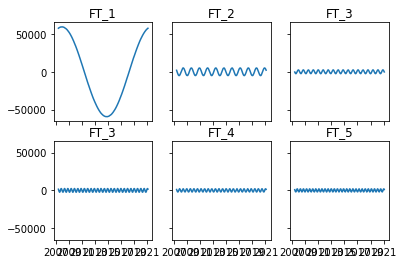

In [21]:

fig, ax = plt.subplots(2, 3, sharex=True, sharey=True)
for i in range(0,2):
    for j in range(0,3):
        ax[i][j].set_title('FT_'+str(j+1+i*2))
        ax[i][j].plot(stockdata_df.index, stockdata_df['FT_'+str(j+1+i*3)])



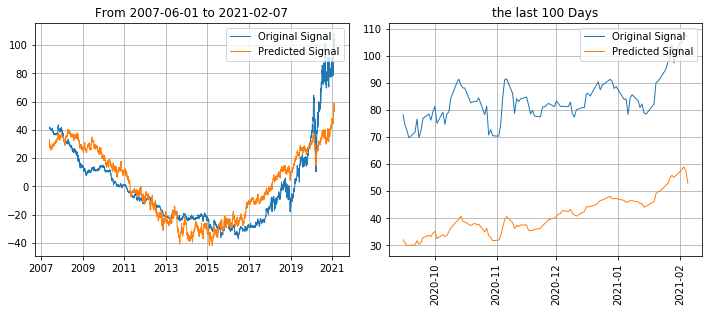

                                 OLS Regression Results                                
Dep. Variable:                   Diff   R-squared (uncentered):                   0.752
Model:                            OLS   Adj. R-squared (uncentered):              0.752
Method:                 Least Squares   F-statistic:                              5229.
Date:                Sun, 07 Feb 2021   Prob (F-statistic):                        0.00
Time:                        20:13:10   Log-Likelihood:                         -14044.
No. Observations:                3447   AIC:                                  2.809e+04
Df Residuals:                    3445   BIC:                                  2.810e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [22]:
X = pd.DataFrame(stockdata_df[['row_num','FT_All']]) 
y = pd.DataFrame(stockdata_df['Diff'])

model = sm.OLS(y, X).fit()
y_predict = model.predict(X) 


plt.figure(figsize=(10, 4))

ax1 = plt.subplot( 1, 2, 1 )
ax1.plot(stockdata_df.index, stockdata_df['Diff'], linewidth=1, label='Original Signal')
ax1.plot(stockdata_df.index, y_predict, linewidth=1, label='Predicted Signal')
ax1.legend(loc='upper right')
ax1.grid()
ax1.set_title("From " + hist + " to " +today)


N=100
ax2 = plt.subplot( 1, 2, 2 )
ax2.plot(stockdata_df.index[-N:], stockdata_df['Diff'][-N:], linewidth=1, label='Original Signal')
ax2.plot(stockdata_df.index[-N:], y_predict[-N:], linewidth=1, label='Predicted Signal')
ax2.legend(loc='upper right')
ax2.grid()
ax2.set_title("the last " + str(N) +" Days")

plt.tight_layout()
plt.xticks(rotation=90)
plt.show()


print(model.summary())